# FIT5196 Assessment 3 : Data Integration and Reshaping
#### Student Name: Roopak Thiyyathuparambil Jayachandran
#### Student ID: 29567467

Date: 13/05/2019

Environment: Python 3.6 and Jupyter notebook
Libraries used: 
* pandas - to hold and manipulate csv data
* matplotlib - for graphical EDA


## 1. Introduction

This task involves integration of several dataset related to house, suburb and train to one schema which will have information about creating housing information in Victoria, Australia.
Given dataset :
 * vic_suburb_boundary.zip,
 * gtfs.zip,
 * Crimebylocation.xlsx
 * 29567467.csv
 * council.txt
 
 Importing the required libraries in the begining

In [1158]:
# Imports
import pandas as pd
import shapefile
import geopandas as gpd
from statistics import median
from shapely.geometry import Polygon, Point, MultiPolygon
import warnings
warnings.filterwarnings('ignore')

Importing the csv to a dataframe. This dataframe will be the basic table to which we will append other data.

In [1159]:
property_info = pd.read_csv("29567467.csv", delimiter=",", encoding="UTF-8")

In [1160]:
property_info.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude
0,ID648060837,8/131 Grange Rd,1,u,260000.0,13/05/2017,1.0,1.0,1162.0,54.0,-37.8911,145.0451
1,ID604692611,76 Newry St,2,h,1116000.0,3/09/2016,1.0,0.0,152.0,109.0,-37.7910,144.9809
2,ID803803522,22 Kyarra Rd,4,h,1857000.0,25/02/2017,2.0,3.0,548.0,89.0,-37.8536,145.0547
3,ID344558125,5/698 Inkerman Rd,2,u,523000.0,7/11/2016,1.0,1.0,0.0,59.0,-37.8694,145.0246
4,ID809539804,5/25 Clarence St,1,u,373000.0,24/09/2016,1.0,1.0,0.0,54.0,-37.8728,145.0417


Understadind the features and data types of each

In [1161]:
property_info.dtypes

ID             object
Address        object
Rooms           int64
Type           object
Price         float64
Date           object
Bathroom      float64
Car           float64
Landsize      float64
Age           float64
Lattitude     float64
Longtitude    float64
dtype: object

In [1162]:
property_info.shape

(720, 12)

720 rows and 12 columns. Checking if there is any duplicate data using ID which is the primary key in the table.

In [1163]:
property_info.ID.nunique()

673

Since there are just 673 unique IDS, it means that we have got duplicates in ID which need to be further investigated

In [1164]:
property_info.ID.value_counts().head(41)

ID308508892    3
ID207189846    3
ID272145538    3
ID667934293    3
ID902722542    3
ID400512415    3
ID619044644    2
ID761201148    2
ID335542969    2
ID132747066    2
ID385240788    2
ID762637732    2
ID680699927    2
ID631354457    2
ID436968030    2
ID692857550    2
ID235847962    2
ID225300670    2
ID684957664    2
ID679296086    2
ID989109617    2
ID708384264    2
ID824053591    2
ID761539925    2
ID583727011    2
ID230635266    2
ID814528510    2
ID952227053    2
ID203669849    2
ID746461786    2
ID833956813    2
ID355816548    2
ID519360390    2
ID175715264    2
ID490089000    2
ID811087539    2
ID113051188    2
ID590249521    2
ID161987324    2
ID615004306    2
ID122710788    2
Name: ID, dtype: int64

In [1165]:
property_info[property_info.ID == 'ID667934293']

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude
498,ID667934293,8/33 Gordon St,1,u,305000.0,17/09/2016,1.0,1.0,59.0,54.0,-37.7903,144.8899
709,ID667934293,8/33 Gordon St,1,u,305000.0,17/09/2016,1.0,1.0,59.0,54.0,-37.7903,144.8899
713,ID667934293,8/33 Gordon St,1,u,305000.0,17/09/2016,1.0,1.0,59.0,54.0,-37.7903,144.8899


On investigating a single ID which has 3 records in the dataframe, we can see that the values are same for all 3 records. Just confirming this nature of duplicates with others also

In [1166]:
property_info[property_info.ID == 'ID902722542']

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude
14,ID902722542,3/4 Lemon Rd,2,u,682000.0,24/06/2017,1.0,1.0,140.0,49.0,-37.79334,145.10025
217,ID902722542,3/4 Lemon Rd,2,u,682000.0,24/06/2017,1.0,1.0,140.0,49.0,-37.79334,145.10025
711,ID902722542,3/4 Lemon Rd,2,u,682000.0,24/06/2017,1.0,1.0,140.0,49.0,-37.79334,145.10025


Deleting the duplicates by keeping the first occurrence.

In [1167]:
property_info.drop_duplicates(keep="first", inplace=True)

In [1168]:
property_info.shape[0]

673

property_info is the basic dataset which has all the columns from the given dataset. These columns are:
    * ID
    * Address
    * Price
    * Type
    * Date
    * Rooms
    * Bathroom
    * Car
    * LandSize
    * Age
    * Latitude
    * Longitude

Need to add:
    * Suburb
    * train_station_id
    * distance_to_train_stat
    * travel_min_to_CBD
    * over_priced?
    * crime_A_average
    * crime_B_average
    * crime_C_average
    

### Suburb

Methodology:
 * Use shapefile package to create polygon(using coordinates) of suburb.
 * FOr each coordinates in property dataframe, iterate through the shape file and check if the coordinate is inside polygon.
 * If coordinate is present in the suburb, then write the suburb name to a new column of property dataframe

Importing the shape file to geopandas to get an overview of the given data

In [1169]:
shapefileshp = gpd.read_file("./vic_suburb_boundary/VIC_LOCALITY_POLYGON_shp.shp")
shapefileshp.head(1)

,LC_PLY_PID,DT_CREATE,DT_RETIRE,LOC_PID,VIC_LOCALI,VIC_LOCA_1,VIC_LOCA_2,VIC_LOCA_3,VIC_LOCA_4,VIC_LOCA_5,VIC_LOCA_6,VIC_LOCA_7,geometry
0,6670,2011-08-31,None,VIC2615,2012-04-27,None,UNDERBOOL,None,None,G,None,2,"POLYGON ((141.74552399 -35.07228701, 141.74552..."


In [1170]:
myshp = open("./vic_suburb_boundary/VIC_LOCALITY_POLYGON_shp.shp", "rb")
myprj = open("./vic_suburb_boundary/VIC_LOCALITY_POLYGON_shp.prj", "rb")
mydbf = open("./vic_suburb_boundary/VIC_LOCALITY_POLYGON_shp.dbf", "rb")
myshx = open("./vic_suburb_boundary/VIC_LOCALITY_POLYGON_shp.shx", "rb")

In [1171]:
r = shapefile.Reader(shp=myshp, dbf=mydbf, prj=myprj, shx=myshx)

In [1172]:
geometry = r.shapes()

In [1173]:
shpfilePoints = [ shape.points for shape in geometry ]

Adding a new column Suburb initialised with default value of "not available"

In [1174]:
property_info["Suburb"] = "not available"

In [1175]:
property_info.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,Suburb
0,ID648060837,8/131 Grange Rd,1,u,260000.0,13/05/2017,1.0,1.0,1162.0,54.0,-37.8911,145.0451,not available
1,ID604692611,76 Newry St,2,h,1116000.0,3/09/2016,1.0,0.0,152.0,109.0,-37.7910,144.9809,not available
2,ID803803522,22 Kyarra Rd,4,h,1857000.0,25/02/2017,2.0,3.0,548.0,89.0,-37.8536,145.0547,not available
3,ID344558125,5/698 Inkerman Rd,2,u,523000.0,7/11/2016,1.0,1.0,0.0,59.0,-37.8694,145.0246,not available
4,ID809539804,5/25 Clarence St,1,u,373000.0,24/09/2016,1.0,1.0,0.0,54.0,-37.8728,145.0417,not available


For each of the coordniates value(latitude and longitude) in property dataset, checking if the coordinates lie inside any of the previously generated polygons for each suburb. If the point is present, iteration is stopped and corressponding Suburb value (VIC_LOCA_2) is inserted to property dataset

In [1176]:
for index1, row in property_info.iterrows():
    suburb = None
    point = Point(row[11], row[10])
    index = 0
    for polygon in shpfilePoints:
        poly = Polygon(polygon)
        a = point.within(poly)
        if a == True:
            break
        index += 1
    if index != 0:
        suburb = shapefileshp.loc[index,'VIC_LOCA_2']
    if suburb is not None and row[0] is not None:
        property_info.set_value(index1, 'Suburb', suburb)

In [1177]:
property_info.tail(5)

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,Suburb
695,ID307843751,5/8 Swan St,2,t,380000.0,10/09/2016,1.0,1.0,161.0,9.0,-37.72510,144.8621,KEILOR PARK
696,ID392319924,54 Balmain St,2,h,1110000.0,24/09/2016,1.0,1.0,144.0,4.0,-37.83010,144.9927,CREMORNE
697,ID746461786,2/16 Beaver St,3,t,1370000.0,22/08/2016,2.0,2.0,323.0,49.0,-37.87040,145.0411,MALVERN EAST
698,ID880818663,18 Empress Rd,2,h,1260000.0,13/05/2017,1.0,0.0,269.0,109.0,-37.82010,145.0887,SURREY HILLS
699,ID783762726,37 Wellington St,4,h,4000000.0,19/08/2017,2.0,3.0,792.0,114.0,-37.80926,145.0331,KEW


Cross verification of the data using geocoder. GeoCoder is not used for any result generation.

In [1178]:
import geocoder

g = geocoder.osm([-37.80926, 145.0331], method='reverse')
g 

<[OK] Osm - Reverse [Wellington Street, Willsmere, Kew, City of Boroondara, Victoria, 3101, Australia]>

### Train station id and Distance travelled

Methodology:
 * Add a new column train_station_id with default value 0.
 * Extract dataset from each of the files and created a common dataset for each file with unique values. Like stops_df,  trips_df, stop_times_df etc
 * From calendar_df retain only those columns which have train on all weekdays
 * Get the service id to a list.
 * From trips_df only retain those columns which have service id present in the above created list.
 * Get the unique trip ids to a list and retain columns in stop_times which have trip id in the trip ids list
 * Create a dictionary to store "Southern Cross Station" arrival times
 * For each record in property, get the station_id which is nearest to the location using Haversine formula.
 * Append the distance travelled to a new column distance_to_train_stat.
 * for same distance to the nearest stop_ids, get the stop_id which will take less time to Southern Cross in the same trip.

In [1179]:
property_info["train_station_id"] = "0"

In [1180]:
stop = pd.read_csv("29567467.csv", delimiter=",", encoding="UTF-8")

In [1181]:
path1 = "./gtfs/"
path2 = "/google_transit/"

From the information, it is understood that folder 1, 2 and 10 have train data which is needed for this analysis. Other folders have information of trams and busses

In [1182]:
def extract(file):
    first = True
    for each in ['1','2','10']:  
        path = path1 + each + path2 + file
        df_temp = pd.read_csv(path, delimiter=",", encoding="UTF-8")
        if first is False:
            df = pd.concat([df, df_temp]) 
        else:
            df = df_temp
            first = False
    # Removing duplicates
    df.drop_duplicates(keep="first", inplace=True)
    return df

In [1183]:
stops_df = extract("stops.txt")
trips_df = extract("trips.txt")
stop_times_df = extract("stop_times.txt")
calendar_df = extract("calendar.txt")

In [1184]:
calendar_df = calendar_df[(calendar_df.monday == 1) & (calendar_df.tuesday == 1) & (calendar_df.wednesday == 1) & (calendar_df.thursday == 1) & (calendar_df.friday == 1)]

In [1185]:
calendar_df

,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
6,T0,1,1,1,1,1,0,0,20190515,20190523
13,T0_1,1,1,1,1,1,0,0,20190530,20190606
16,T0_2,1,1,1,1,1,0,0,20190607,20190628
20,T0_3,1,1,1,1,1,0,0,20190629,20190810
11,T0,1,1,1,1,1,0,0,20190524,20190810


In [1186]:
trips_df = trips_df[trips_df.service_id.isin(calendar_df.service_id.tolist())]

In [1187]:
set_trip_id = set(trips_df.trip_id.tolist())
set_trip_id_list = list(set_trip_id)
stop_times_df = stop_times_df[stop_times_df.trip_id.isin(set_trip_id_list)]

In [1188]:
stop_times_df = pd.merge(stop_times_df, stops_df, on='stop_id', how='left')

In [1189]:
property_info.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,Suburb,train_station_id
0,ID648060837,8/131 Grange Rd,1,u,260000.0,13/05/2017,1.0,1.0,1162.0,54.0,-37.8911,145.0451,GLEN HUNTLY,0
1,ID604692611,76 Newry St,2,h,1116000.0,3/09/2016,1.0,0.0,152.0,109.0,-37.7910,144.9809,FITZROY NORTH,0
2,ID803803522,22 Kyarra Rd,4,h,1857000.0,25/02/2017,2.0,3.0,548.0,89.0,-37.8536,145.0547,GLEN IRIS,0
3,ID344558125,5/698 Inkerman Rd,2,u,523000.0,7/11/2016,1.0,1.0,0.0,59.0,-37.8694,145.0246,CAULFIELD NORTH,0
4,ID809539804,5/25 Clarence St,1,u,373000.0,24/09/2016,1.0,1.0,0.0,54.0,-37.8728,145.0417,MALVERN EAST,0


In [1190]:
stop_list = list(set(stop_times_df.stop_id.tolist()))

In [1191]:
from math import sin, cos, sqrt, atan2, radians
def coordinate_distance(la1, lo1, la2, lo2):
    # approximate radius of earth in km
    R = 6378000.0

    lat1 = radians(la1)
    lon1 = radians(lo1)
    lat2 = radians(la2)
    lon2 = radians(lo2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

In [1192]:
stops_df.columns

Index(['stop_id', 'stop_name', 'stop_lat', 'stop_lon'], dtype='object')

In [1193]:
property_info["stop_id"] = "-1"
property_info["distance_to_train_stat"] = 0.0

In [1194]:
for index, row in property_info.iterrows():
    lat = row[10]
    lon = row[11]
    equal_dist = []
    first = True
    min_d = 0
    for index2, row2 in stops_df.iterrows():
        lat2 = row2[2]
        lon2 = row2[3]
        distance = coordinate_distance(lat, lon, lat2, lon2)
        if first is True:
            min_dist = distance
            first = False
            continue
        if distance <= min_dist:
            if distance == min_dist:
                if row2[0] in stop_list:
                    equal_dist.append(row2[0])
                    continue
            if distance < min_dist:
                min_dist = distance
                equal_dist.clear()
                if(row2[0] in stop_list):
                    equal_dist.append(row2[0])         
        min_d = min_dist
    
    equal_dist = list(set(equal_dist))
    property_info.set_value(index, 'stop_id', equal_dist)
    property_info.set_value(index, 'distance_to_train_stat', min_d)
    

In [1195]:
stops_in_prop = []
for index, row in property_info.iterrows():
    stops_in_prop.extend(row[14])
stops_in_prop = list(set(stops_in_prop))

In [1196]:
stops_in_prop.append(20043)
stops_in_prop.append(22180)

In [1197]:
stop_times_df = stop_times_df[stop_times_df.stop_id.isin(stops_in_prop)]
stop_times_df.shape

(41849, 12)

In [1198]:
stop_times_df.head(1)

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,stop_name,stop_lat,stop_lon
11,1051.T0.1-V08-G-mjp-1.1.H,09:09:00,09:09:00,22250,18,NaN,1,0,244167.376904,Dandenong Railway Station (Dandenong),-37.989968,145.209725


In [1199]:
southern_cross_arrival_dict = {}
for index, row in stop_times_df.iterrows():
    if row[3] == 20043 or row[3] == 22180:
        southern_cross_arrival_dict[row[0]] = row[1] 
        

In [1200]:
stop_times_df = stop_times_df[(stop_times_df.departure_time > '07:00:00') & (stop_times_df.departure_time < '09:30:00')]

In [1201]:
stop_times_df.shape

(8334, 12)

In [1202]:
from datetime import datetime
FMT = '%H:%M:%S'

property_info["dict"] = ""

for index, row in property_info.iterrows():
    dict_stop = {}
    stop_list = row[14]
    if(len(stop_list) == 1):
        property_info.set_value(index, 'train_station_id', stop_list[0])
        property_info.set_value(index, "dict", dict_stop)
    if(len(stop_list) > 1):
        stop_id = ""
        trip_id = ""
        departure = ""
        arrival = ""
        for index2, row2 in stop_times_df.iterrows():
            if row2[3] not in stop_list:
                continue
            if row2[3] in stop_list:
                stop_id = row2[3]
                trip_id = row2[0]
                departure = row2[2]
                if trip_id in southern_cross_arrival_dict.keys():
                    arrival = southern_cross_arrival_dict[trip_id]
                    if arrival > departure:
                        time = datetime.strptime(arrival, FMT) - datetime.strptime(departure, FMT)
                    else:
                        continue
                    dict_stop[stop_id] = time
                else:
                    continue
        property_info.set_value(index, "dict", dict_stop)

In [1203]:
from datetime import datetime
FMT = '%H:%M:%S'
tdelta1 = datetime.strptime("06:00:00", FMT)
tdelta2 = datetime.strptime("08:00:00", FMT)
print(tdelta2 - tdelta1)

2:00:00


In [1204]:
property_info.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,Suburb,train_station_id,stop_id,distance_to_train_stat,dict
0,ID648060837,8/131 Grange Rd,1,u,260000.0,13/05/2017,1.0,1.0,1162.0,54.0,-37.8911,145.0451,GLEN HUNTLY,19942,[19942],295.809056,{}
1,ID604692611,76 Newry St,2,h,1116000.0,3/09/2016,1.0,0.0,152.0,109.0,-37.7910,144.9809,FITZROY NORTH,19974,[19974],1303.384256,{}
2,ID803803522,22 Kyarra Rd,4,h,1857000.0,25/02/2017,2.0,3.0,548.0,89.0,-37.8536,145.0547,GLEN IRIS,19912,[19912],270.040873,{}
3,ID344558125,5/698 Inkerman Rd,2,u,523000.0,7/11/2016,1.0,1.0,0.0,59.0,-37.8694,145.0246,CAULFIELD NORTH,19944,[19944],541.150936,{}
4,ID809539804,5/25 Clarence St,1,u,373000.0,24/09/2016,1.0,1.0,0.0,54.0,-37.8728,145.0417,MALVERN EAST,0,"[22248, 19943]",523.716330,"{22248: 0:20:00, 19943: 0:20:00}"


In [1205]:
import numpy as np
for index, row in property_info.iterrows():
    dict_stops = row[16]
    if len(dict_stops) == 0:
        continue
    dict_stops = sorted(dict_stops.items(), key=lambda x: x[1])
    for k,v in dict_stops:
        property_info.set_value(index, "train_station_id", k)
        break
        

In [1206]:
property_info[property_info.ID == "ID998136226"]

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,Suburb,train_station_id,stop_id,distance_to_train_stat,dict
7,ID998136226,241 Buckley St,4,h,1380000.0,12/08/2017,2.0,2.0,766.0,139.0,-37.75595,144.90551,ABERFELDIE,22253,"[20037, 22253]",940.633699,"{22253: 0:18:00, 20037: 0:24:00}"


In [1207]:
property_info.drop(["dict"], inplace=True, axis=1)

In [1208]:
property_info.drop(["stop_id"], inplace=True, axis=1)
property_info.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,Suburb,train_station_id,distance_to_train_stat
0,ID648060837,8/131 Grange Rd,1,u,260000.0,13/05/2017,1.0,1.0,1162.0,54.0,-37.8911,145.0451,GLEN HUNTLY,19942,295.809056
1,ID604692611,76 Newry St,2,h,1116000.0,3/09/2016,1.0,0.0,152.0,109.0,-37.7910,144.9809,FITZROY NORTH,19974,1303.384256
2,ID803803522,22 Kyarra Rd,4,h,1857000.0,25/02/2017,2.0,3.0,548.0,89.0,-37.8536,145.0547,GLEN IRIS,19912,270.040873
3,ID344558125,5/698 Inkerman Rd,2,u,523000.0,7/11/2016,1.0,1.0,0.0,59.0,-37.8694,145.0246,CAULFIELD NORTH,19944,541.150936
4,ID809539804,5/25 Clarence St,1,u,373000.0,24/09/2016,1.0,1.0,0.0,54.0,-37.8728,145.0417,MALVERN EAST,22248,523.716330


In [1209]:
property_info.columns

Index(['ID', 'Address', 'Rooms', 'Type', 'Price', 'Date', 'Bathroom', 'Car',
       'Landsize', 'Age', 'Lattitude', 'Longtitude', 'Suburb',
       'train_station_id', 'distance_to_train_stat'],
      dtype='object')

In [1210]:
stop_times_df.shape

(8334, 12)

### travel_min_to_CBD

Methodology:
 * Add a new column in property_info dataset with default value 0
 * From previous part we have created a dictionary which will save trip id with arrival time of Southern Cross as value. This will act as a lookup dictionary.
 * for each stop_id in property data structure, iterate through the stop times, get trip id and find the difference between time stopid departure time and southern cross arrival time, append this to a list.
 * After the iteration, the average of times will be appended to the column

In [1211]:
property_info["travel_min_to_CBD"] = "0"

for index, row in property_info.iterrows():
    stop_id = row[13]
    time_list = []
    departure = ""
    for index2, row2 in stop_times_df.iterrows():
        if stop_id != row2[3]:
            continue
        if stop_id == row2[3]:
            departure = row2[2]
            trip_id = row2[0]
            if trip_id in southern_cross_arrival_dict.keys():
                arrival = southern_cross_arrival_dict[trip_id]
            if arrival > departure:
                time = datetime.strptime(arrival, FMT) - datetime.strptime(departure, FMT)
                time_list.append(time.total_seconds())
            else:
                continue

    time_list = list(set(time_list))
    if len(time_list) > 0:
        property_info.set_value(index, "travel_min_to_CBD", sum(time_list)/len(time_list))

### over_priced?

Methodology:
 * Iterate through the property dataset, create a dictionary and populate the dictionary with the similar properties(using concat function) as key and price appended to a list as value.
 * Find the median of prices and replace the value in dictionary
 * Iterate through the property dataset and if the price is greater than median, insert value 1 to over_priced else 0

Adding a new feature to property_info dataframe to indicate over-price

In [1212]:
property_info["over_priced?"] = "-1"

Adding a temporary column to calculate over-price. This will contain a generated hash value which will be used as a key to the dictionary

In [1213]:
property_info["hash"] = "-1"

A function which will be used to generate a key to the dictionary. Key will be a concatenated string after extracting rooms, house type, car parking, bathroom, suburb and year 

In [1214]:
def concat(a, b, c, d, e, f):
    final = str(a) + str(b) + str(c) + str(d) + str(e) + str(f)
    return final

In [1215]:
# An empty dictionary
similar_prop = {}

# Iterates through all the records and populate the dictionary
for index, row in property_info.iterrows():
    rooms = row[2]
    house_type = row[3]
    car_parking = row[7]
    bathroom = row[6]
    suburb = row[12]
    year = row[5].split("/")[2]
    first = concat(rooms, house_type, car_parking, bathroom, suburb, year)
    if first in similar_prop.keys():
        li = similar_prop[first]
        li.append(row[4])
    else:
        similar_prop[first] = [row[4]]

The populated dictionary will have the list of prices as value. Calculating the median of the price below:

In [1216]:
for k,v in similar_prop.items():
    v = sorted(v)
    v = median(v)
    similar_prop[k] = v    

Iterating through all the columns and checking if the price is greater than the median value.

In [1217]:
for index, row in property_info.iterrows():
    rooms = row[2]
    house_type = row[3]
    car_parking = row[7]
    bathroom = row[6]
    suburb = row[12]
    year = row[5].split("/")[2]
    first = concat(rooms, house_type, car_parking, bathroom, suburb, year)
    if first in similar_prop.keys():
        if row[4] > similar_prop[first]:
            property_info.set_value(index, 'over_priced?', 1)
        else:
            property_info.set_value(index, 'over_priced?', 0)
    else:
        property_info.set_value(index, 'over_priced?', -1)
    

In [1218]:
property_info["over_priced?"].value_counts()

0    620
1     53
Name: over_priced?, dtype: int64

In the given dataset, 53 records are over-priced

In [1219]:
# Dropping the extra temporary column hash
property_info.drop(["hash"], inplace=True, axis=1)

In [1220]:
property_info.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,Suburb,train_station_id,distance_to_train_stat,travel_min_to_CBD,over_priced?
0,ID648060837,8/131 Grange Rd,1,u,260000.0,13/05/2017,1.0,1.0,1162.0,54.0,-37.8911,145.0451,GLEN HUNTLY,19942,295.809056,2320,0
1,ID604692611,76 Newry St,2,h,1116000.0,3/09/2016,1.0,0.0,152.0,109.0,-37.7910,144.9809,FITZROY NORTH,19974,1303.384256,3810,0
2,ID803803522,22 Kyarra Rd,4,h,1857000.0,25/02/2017,2.0,3.0,548.0,89.0,-37.8536,145.0547,GLEN IRIS,19912,270.040873,3400,0
3,ID344558125,5/698 Inkerman Rd,2,u,523000.0,7/11/2016,1.0,1.0,0.0,59.0,-37.8694,145.0246,CAULFIELD NORTH,19944,541.150936,1883.08,0
4,ID809539804,5/25 Clarence St,1,u,373000.0,24/09/2016,1.0,1.0,0.0,54.0,-37.8728,145.0417,MALVERN EAST,22248,523.716330,2420,0


### crime columns

Methodology:
 * Extract the crime and council dataset
 * Remove unwanted records from crime dataset
 * Iterate through the property dataset, get the suburb, get the council and add crimes for each each type
 * Find the average of each type
 * Populate the columns

In [1221]:
crime = pd.read_excel("crimebylocationdatatable-yearending31march2016.xlsx", sheet_name='Table 1')

In [1222]:
crime = crime[17:]

In [1223]:
crime.columns = crime.iloc[0]
crime.head()

17,nan,Apr - Mar reference period,Police Region,Police Service Area,Local Government Area,CSA Offence Division,CSA Offence Subdivision,Offence Count,LGA ERP,Victorian ERP
17,NaN,Apr - Mar reference period,Police Region,Police Service Area,Local Government Area,CSA Offence Division,CSA Offence Subdivision,Offence Count,LGA ERP,Victorian ERP
18,NaN,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A10 Homicide and related offences,4,123600,5632521
19,NaN,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A20 Assault and related offences,568,123600,5632521
20,NaN,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A30 Sexual offences,132,123600,5632521
21,NaN,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A40 Abduction and related offences,12,123600,5632521


In [1224]:
crime.shape

(9086, 10)

In [1225]:
crime = crime[crime["Offence Count"] != "Offence Count"]

In [1226]:
crime.drop(crime.columns[0], axis=1, inplace=True)

In [1227]:
crime["CSA Offence Division"].head()

18    A Crimes against the person
19    A Crimes against the person
20    A Crimes against the person
21    A Crimes against the person
22    A Crimes against the person
Name: CSA Offence Division, dtype: object

In [1228]:
council = open("council_dataset", "r")
council_data = council.read()
council_data = council_data.upper()
council.close()

In [1229]:
council_data_list = council_data.split("\n")

In [1230]:
council_data_list[0]

"BANYULE : ['ABBOTSFORD', 'AIRPORT WEST', 'ALBERT PARK', 'ALPHINGTON']"

Adding 3 new columns crime_A_average, crime_B_average and crime_C_average with default value -1

In [1231]:
property_info["crime_A_average"] = "-1"
property_info["crime_B_average"] = "-1"
property_info["crime_C_average"] = "-1"

Crime dataset has 9086 columns and iterating this many columns 700 times can be very time consuming. Removing the records which are not needed.
Our given dataset has records in year 2016 and 2017, so council data of 2012 is not useful. 

In [1232]:
crime = crime[crime["Apr - Mar reference period"] > 2012]

Removing the suburbs which are not present in property dataset

Removing the dataset which are not of Crime type A, B or C

In [1233]:
crime = crime[(crime["CSA Offence Division"] == "A Crimes against the person") | (crime["CSA Offence Division"] == "B Property and deception offences") | (crime["CSA Offence Division"] == "C Drug offences")]

In [1234]:
crime["CSA Offence Division"].value_counts()

A Crimes against the person          2158
B Property and deception offences    1608
C Drug offences                       982
Name: CSA Offence Division, dtype: int64

In [1235]:
crime.shape

(4748, 9)

In [1236]:
property_info.columns

Index(['ID', 'Address', 'Rooms', 'Type', 'Price', 'Date', 'Bathroom', 'Car',
       'Landsize', 'Age', 'Lattitude', 'Longtitude', 'Suburb',
       'train_station_id', 'distance_to_train_stat', 'travel_min_to_CBD',
       'over_priced?', 'crime_A_average', 'crime_B_average',
       'crime_C_average'],
      dtype='object')

In [1237]:
crime.columns

Index(['Apr - Mar reference period', 'Police Region', 'Police Service Area',
       'Local Government Area', 'CSA Offence Division',
       'CSA Offence Subdivision', 'Offence Count', 'LGA ERP', 'Victorian ERP'],
      dtype='object', name=17)

The final crime dataset has 184 columns which can be iterated more quickly

In [1238]:
# Function to extract Suburb, find the council and find the mean crime for each type
for index, row in property_info.iterrows():
    date = row[5]
    year = int(date.split("/")[2])
    date_list = [year-1,year-2, year-3]
    suburb = row[12]
    council = ""
    a_list = []
    b_list = []
    c_list = []
    for each in council_data_list:
        if suburb in each:
            council = each.split(":")[0][:-1]
    for index2, row2 in crime.iterrows():
        if int(row2[0]) in date_list and council == row2[3]:
            if row2[4].startswith("A"):
                a_list.append(row2[6])
            if row2[4].startswith("B"):
                b_list.append(row2[6])
            if row2[4].startswith("C"):
                c_list.append(row2[6])
    if len(a_list) > 0:
        a_mean = sum(a_list)/len(a_list)
        property_info.set_value(index, 'crime_A_average', a_mean)
    
    if len(b_list) > 0:
        b_mean = sum(b_list)/len(b_list)
        property_info.set_value(index, 'crime_B_average', b_mean)
    
    if len(c_list) > 0:
        c_mean = sum(c_list)/len(c_list)
        property_info.set_value(index, 'crime_C_average', c_mean)
        

Rearranging the column names in the order given the assignment specification 

In [1239]:
property_info = property_info[['ID', 'Address', 'Suburb', 'Price', 'Type', 'Date', 'Rooms', 'Bathroom', 'Car', 'Landsize', 'Age', 'Lattitude', 'Longtitude', 'train_station_id',
                     'distance_to_train_stat','travel_min_to_CBD','over_priced?','crime_A_average', 'crime_B_average', 'crime_C_average']]

Some column names are different in the given assignment specification. Correcting that:

In [1240]:
property_info.rename({'Landsize': 'LandSize', 'Lattitude':'Latitude', 'Longtitude':'Longitude', 'distance_to_train_stat':'distance_to_train_station'}, inplace=True)

### Final dataset

In [1241]:
property_info.to_csv("29567467_solution.csv", sep=',')
property_info.tail(20)

,ID,Address,Suburb,Price,Type,Date,Rooms,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,train_station_id,distance_to_train_stat,travel_min_to_CBD,over_priced?,crime_A_average,crime_B_average,crime_C_average
680,ID243441109,126 Albert St,PRESTON,600000.0,h,12/06/2016,3,1.0,3.0,503.0,69.0,-37.73900,145.02380,20012,2049.497406,2048.57,0,85.9565,1043.87,112.778
681,ID815334022,171 Essex St,WEST FOOTSCRAY,879000.0,h,23/09/2017,3,1.0,2.0,377.0,69.0,-37.79285,144.86969,20022,927.209698,2190,0,42.5714,147,51.3333
682,ID949891292,8 Campbell St,KEW,1528500.0,h,4/03/2017,3,1.0,1.0,375.0,89.0,-37.80150,145.05050,19903,2362.104752,2470.91,0,41.1429,142.4,25.2222
683,ID158008948,8 Jerrold St,FOOTSCRAY,752000.0,h,7/05/2016,2,1.0,0.0,215.0,109.0,-37.79220,144.89100,20024,1147.840135,2600,0,36.5909,147.2,42.7778
684,ID454059105,8/5 Gordon St,TOORAK,405000.0,u,14/05/2016,1,1.0,1.0,0.0,49.0,-37.84400,145.00500,19947,259.694984,1660,0,79.6818,512.188,63.5
685,ID315313187,1 Estella St,GLEN IRIS,2920000.0,h,27/05/2017,4,3.0,3.0,1064.0,144.0,-37.86224,145.06406,19835,607.847890,3105,0,255.958,1618.41,222.7
686,ID783237528,52 Stawell St,COBURG,841000.0,h,19/11/2016,3,1.0,3.0,385.0,99.0,-37.73400,144.96030,19964,229.881808,4851.43,0,133.917,1156.73,139.889
687,ID921825693,3/5 Florence Rd,SURREY HILLS,865000.0,t,25/02/2017,3,1.0,1.0,217.0,49.0,-37.82750,145.10320,19895,539.099140,2382,0,316.542,1022.81,237.667
688,ID567412321,53 Fordham Rd,RESERVOIR,685000.0,h,3/12/2016,3,1.0,1.0,1262.0,64.0,-37.71390,145.02150,20009,1249.048556,3234,0,117.81,378.067,47.8
689,ID112632898,1/14 Forrester St,ESSENDON,645000.0,u,10/09/2016,2,1.0,1.0,228.0,49.0,-37.75310,144.90590,22253,962.516625,1110,0,143.042,1283.56,102.455


### Task 2: data reshaping

Studying the effect of different normalization/transformation methods (i.e.
standardization, min-max normalization, log, power, and root transformation) on Rooms ,
crime_C_average, travel_min_to_CBD , and property_age attributes

In [1242]:
%matplotlib inline

from matplotlib import pyplot as plt

In [1243]:
plot_property_z = property_info.copy()
plot_property_min_max = property_info.copy()

In [1244]:
plot_property_z.dtypes

ID                         object
Address                    object
Suburb                     object
Price                     float64
Type                       object
Date                       object
Rooms                       int64
Bathroom                  float64
Car                       float64
Landsize                  float64
Age                       float64
Lattitude                 float64
Longtitude                float64
train_station_id           object
distance_to_train_stat    float64
travel_min_to_CBD          object
over_priced?               object
crime_A_average            object
crime_B_average            object
crime_C_average            object
dtype: object

In [1245]:
plot_property_z['crime_C_average'] = plot_property_z['crime_C_average'].astype(float)
plot_property_z['Age'] = plot_property_z['Age'].astype(float)
plot_property_z['travel_min_to_CBD'] = plot_property_z['travel_min_to_CBD'].astype(float)

Using z-score value to standardize the columns

In [1246]:
from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(plot_property_z[['crime_C_average', 'Age','travel_min_to_CBD','Rooms']])
df_std = std_scale.transform(plot_property_z[['crime_C_average', 'Age','travel_min_to_CBD','Rooms' ]]) 


In [1247]:
plot_property_z['crime_C_average_z'] = df_std[:,0]
plot_property_z['Age_z'] = df_std[:,1]
plot_property_z['travel_min_to_CBD_z'] = df_std[:,2]
plot_property_z['Rooms_z'] = df_std[:,3]

plot_property_z.head()

,ID,Address,Suburb,Price,Type,Date,Rooms,Bathroom,Car,Landsize,...,distance_to_train_stat,travel_min_to_CBD,over_priced?,crime_A_average,crime_B_average,crime_C_average,crime_C_average_z,Age_z,travel_min_to_CBD_z,Rooms_z
0,ID648060837,8/131 Grange Rd,GLEN HUNTLY,260000.0,u,13/05/2017,1,1.0,1.0,1162.0,...,295.809056,2320.000000,0,66.7,196.267,71.900000,-0.472933,-0.032520,-0.457476,-1.991321
1,ID604692611,76 Newry St,FITZROY NORTH,1116000.0,h,3/09/2016,2,1.0,0.0,152.0,...,1303.384256,3810.000000,0,240.458,1683.62,169.181818,0.378998,1.489271,0.756021,-0.975279
2,ID803803522,22 Kyarra Rd,GLEN IRIS,1857000.0,h,25/02/2017,4,2.0,3.0,548.0,...,270.040873,3400.000000,0,255.958,1618.41,222.700000,0.847675,0.935893,0.422106,1.056804
3,ID344558125,5/698 Inkerman Rd,CAULFIELD NORTH,523000.0,u,7/11/2016,2,1.0,1.0,0.0,...,541.150936,1883.076923,0,200.957,1136.69,143.300000,0.152342,0.105824,-0.813318,-0.975279
4,ID809539804,5/25 Clarence St,MALVERN EAST,373000.0,u,24/09/2016,1,1.0,1.0,0.0,...,523.716330,2420.000000,0,87.1429,348.733,76.000000,-0.437028,-0.032520,-0.376033,-1.991321


In [1248]:
plot_property_z = plot_property_z[['Price','crime_C_average_z','Age_z','travel_min_to_CBD_z','Rooms_z']]
plot_property_z.head()

,Price,crime_C_average_z,Age_z,travel_min_to_CBD_z,Rooms_z
0,260000.0,-0.472933,-0.032520,-0.457476,-1.991321
1,1116000.0,0.378998,1.489271,0.756021,-0.975279
2,1857000.0,0.847675,0.935893,0.422106,1.056804
3,523000.0,0.152342,0.105824,-0.813318,-0.975279
4,373000.0,-0.437028,-0.032520,-0.376033,-1.991321


As it is seen that on doing data transformation using z-score standarization, we are getting negative values for room, time etc which is ideally incorrect, so for this scenario min max will be a better approach to move with

In [1249]:
plot_property_min_max = plot_property_min_max[['Price','crime_C_average','Age','travel_min_to_CBD','Rooms']]

In [1250]:
plot_property_min_max.columns

Index(['Price', 'crime_C_average', 'Age', 'travel_min_to_CBD', 'Rooms'], dtype='object')

In [1251]:
plot_property_min_max['crime_C_average'] = plot_property_min_max['crime_C_average'].astype(float)
plot_property_min_max['Age'] = plot_property_min_max['Age'].astype(float)
plot_property_min_max['travel_min_to_CBD'] = plot_property_min_max['travel_min_to_CBD'].astype(float)

In [1252]:
for index,row in plot_property_min_max.iterrows():
    plot_property_min_max.set_value(index, 'crime_C_average', (row[1] - plot_property_min_max['crime_C_average'].min())/(plot_property_min_max['crime_C_average'].max()- plot_property_min_max['crime_C_average'].min()))
    plot_property_min_max.set_value(index, 'Age', (row[2] - plot_property_min_max['Age'].min())/(plot_property_min_max['Age'].max()- plot_property_min_max['Age'].min()))
    plot_property_min_max.set_value(index, 'travel_min_to_CBD', (row[3] - plot_property_min_max['travel_min_to_CBD'].min())/(plot_property_min_max['travel_min_to_CBD'].max()- plot_property_min_max['travel_min_to_CBD'].min()))
    plot_property_min_max.set_value(index, 'Rooms', (row[4] - plot_property_min_max['Rooms'].min())/(plot_property_min_max['Rooms'].max()- plot_property_min_max['Rooms'].min()))
plot_property_min_max.head()   
    
    

,Price,crime_C_average,Age,travel_min_to_CBD,Rooms
0,260000.0,0.127518,0.366197,0.359133,0
1,1116000.0,0.303578,0.756325,0.589783,0
2,1857000.0,0.399683,0.617082,0.526316,0
3,523000.0,0.257101,0.408217,0.291498,0
4,373000.0,0.136247,0.373407,0.374613,0


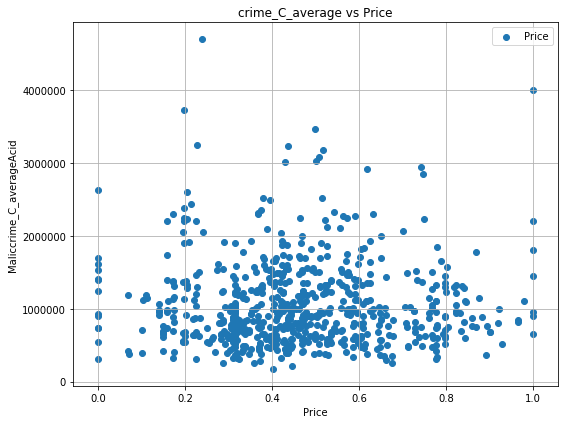

In [1253]:
f = plt.figure(figsize=(8,6))
plt.scatter(plot_property_min_max['travel_min_to_CBD'], plot_property_min_max['Price'])
plt.title('crime_C_average vs Price')
plt.xlabel('Price')
plt.ylabel('Maliccrime_C_averageAcid')
plt.legend(loc='upper right')
plt.grid()
plt.tight_layout()

In [1254]:
plot_property_min_max['travel_min_to_CBD_log'] = plot_property_min_max['travel_min_to_CBD'].apply(np.log)
plot_property_min_max['travel_min_to_CBD_squ'] = plot_property_min_max['travel_min_to_CBD'].apply(lambda x: x**2)
plot_property_min_max['travel_min_to_CBD_cube'] = plot_property_min_max['travel_min_to_CBD'].apply(lambda x: x**3)
plot_property_min_max['travel_min_to_CBD_sq'] = plot_property_min_max['travel_min_to_CBD'].apply(lambda x: x**0.5)

Trying out different transformation for travel_min_to_CBD_log like log, square, cube and square root

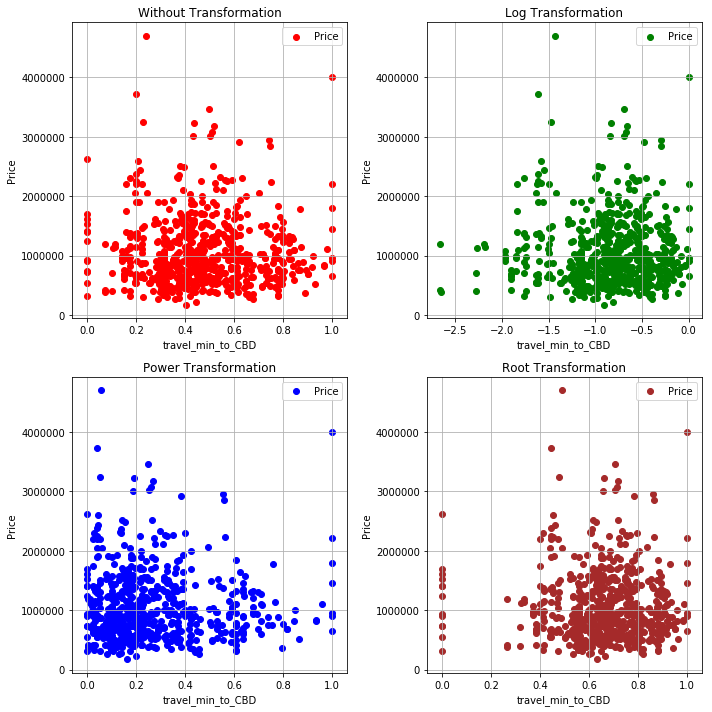

In [1255]:
f = plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.scatter(plot_property_min_max['travel_min_to_CBD'], plot_property_min_max['Price'], color='red')
plt.title('Without Transformation')
plt.xlabel('travel_min_to_CBD')
plt.ylabel('Price')
plt.legend(loc='upper right')
plt.grid()
plt.tight_layout()

plt.subplot(2,2,2)
plt.scatter(plot_property_min_max['travel_min_to_CBD_log'], plot_property_min_max['Price'], color='green')
plt.title('Log Transformation')
plt.xlabel('travel_min_to_CBD')
plt.ylabel('Price')
plt.legend(loc='upper right')
plt.grid()
plt.tight_layout()

plt.subplot(2,2,3)
plt.scatter(plot_property_min_max['travel_min_to_CBD_squ'], plot_property_min_max['Price'], color='blue')
plt.title('Power Transformation')
plt.xlabel('travel_min_to_CBD')
plt.ylabel('Price')
plt.legend(loc='upper right')
plt.grid()
plt.tight_layout()

plt.subplot(2,2,4)
plt.scatter(plot_property_min_max['travel_min_to_CBD_sq'], plot_property_min_max['Price'], color='brown')
plt.title('Root Transformation')
plt.xlabel('travel_min_to_CBD')
plt.ylabel('Price')
plt.legend(loc='upper right')
plt.grid()
plt.tight_layout()

In [1256]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
X_train, X_test, y_train, y_test = train_test_split(plot_property_min_max[['travel_min_to_CBD']],plot_property_min_max['Price'], random_state=1000)
model = LinearRegression()
model.fit(X_train,y_train)
print('R-squared: ',model.score(X_test,y_test))


R-squared:  -0.0037143902044347588


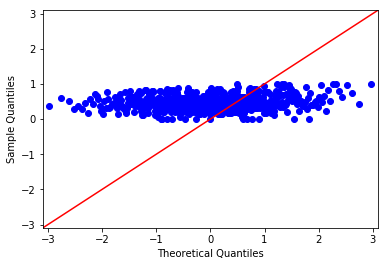

In [1257]:
import numpy as np
import statsmodels.api as sm
import pylab

test = np.random.normal(0,1, 1000)

sm.qqplot(plot_property_min_max[['travel_min_to_CBD']], line='45')
pylab.show()

As it is clear from the log log plot of travel_min_to_CBD, feature travel_min_to_CBD do not follow a normal distribution. Also the linear model r-squared value is very less showing that the linear approach is not correct for this. Similarly for other features also we have similar results